
# Setup

First, we clone the UniverSeg repo and install necessary dependencies

In [1]:
import os
os.environ['HTTP_PROXY']="http://proxy.l2.med.tohoku.ac.jp:8080"
os.environ['HTTPS_PROXY']="http://proxy.l2.med.tohoku.ac.jp:8080"

In [2]:
!git clone https://github.com/JJGO/UniverSeg
!python -m pip install -q --proxy=http://proxy.l2.med.tohoku.ac.jp:8080 -r ./UniverSeg/requirements.txt

fatal: destination path 'UniverSeg' already exists and is not an empty directory.

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install -q --proxy=http://proxy.l2.med.tohoku.ac.jp:8080 tqdm


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
# !pip list

In [5]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E
import torch
import torch.nn.functional as F
from torchvision.transforms import functional as TF

/root/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Prepare `universeg`: import, setup GPU, and load model

In [6]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

Prepare a quick helpful function for visualizing data for this tutorial

In [7]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

# 表示　とりあえずにbinaryに変換

In [8]:
from collections import defaultdict
import os
import numpy as np

In [9]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    if (y_pred.sum() + y_true.sum()) == 0:
        score = 0
    else: score = score.item()
    return score

In [10]:
def rotation_yama(im, angle):
    im = TF.to_pil_image(im.squeeze())
    im = TF.rotate(im, angle)
    im = TF.to_tensor(im)
    return im

In [15]:
# # run inference and compute losses for one test image
# @torch.no_grad()
# def inference(model, image, label, support_images, support_labels):
#     # inference
#     # angles = [0, 90, 180, 360]
#     angles = [0]
#     for angle in angles:
#         im, la = rotation_yama(image, angle).to(device), label.to(device)
#         log = model(
#             im[None],
#             support_images[None],
#             support_labels[None]
#         )[0] # outputs are logits
#         log = rotation_yama(log.cpu(),360-angle).to(device)
#         soft_pred = torch.sigmoid(log)
#         hard_pred = soft_pred.round().clip(0,1)
#         if angle == 0:
#             hard_preds = hard_pred
#         else: hard_preds = hard_preds + hard_pred
#     hard_predf = hard_preds/len(angles)
    

#     #  score
#     score = dice_score(hard_predf, la)

#     # return a dictionary of all relevant variables
#     return {'Image': im,
#             # 'Soft Prediction': soft_predf,
#             'Prediction': hard_pred,
#             'Ground Truth': la,
#             'score': score}

In [12]:
# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

### 関数バージョン

In [15]:
def calculator(organ, image_n):
    file_name = os.listdir(os.path.join("../data4_only_labeltrue/", organ, 'imagesTr'))[image_n]
    source_case_images_path = os.path.join("../data4_only_labeltrue/", organ, 'imagesTr', file_name)
    source_case_labels_path = os.path.join("../data4_only_labeltrue/", organ, 'labelsTr', file_name)
    print(source_case_images_path)

    images = torch.load(source_case_images_path).to('cuda:0')
    images = (images - images.min()) / (images.max() - images.min())
    labels = torch.load(source_case_labels_path).to('cuda:0')
    labels = (labels > 0).int()
    L = images.size()[0]
    n = 5
    # scores_at_all_m = np.full((L, 1), np.nan).tolist()

    if n % 2 == 0:
        m = int(L/2) - int(n//2)
    elif n % 2 ==1:
        m = int(L/2) - int((n//2) + 1)
    scores_at_specific_m = np.full(L, np.nan).tolist()
    images_at_specific_m = torch.full((L, images.size()[2], images.size()[3]), float('nan'))
    label_at_specific_m = torch.full((L, images.size()[2], images.size()[3]), float('nan'))
    prediction_at_specific_m = torch.full((L, images.size()[2], images.size()[3]), float('nan'))
    
    if m+n <= L:
        # anterograde ##########################################
        if (m+n) != L:
            support_images = images[m:(m+n), :, :, :].float()
            support_labels = labels[m:(m+n), :, :, :].float()
            support_images0 = images[m:(m+n), :, :, :].float()
            support_labels0 = labels[m:(m+n), :, :, :].float()
            results_antero = defaultdict(list)

            #parameter
            angles = [0,90,180,270]
            for p in range(len(support_images0)):
                for angle in angles:
                    support_images = torch.cat((support_images, rotation_yama(support_images0[p].cpu(), angle).to(device).unsqueeze(0)), dim=0)
                    support_labels = torch.cat((support_labels, rotation_yama(support_labels0[p].cpu(), angle).to(device).unsqueeze(0)), dim=0)

            for i in range(L-(m+n)):
                print(m+n+i, L-(m+n))
                image = images[(m+n+i), :, :, :].float()
                label = labels[(m+n+i), :, :, :].float()

                # plt.subplot(1,3, 1)
                # plt.imshow(image.squeeze().cpu(), cmap='gray')
                # image2 = rotation_yama(image, 180)
                # plt.subplot(1,3, 2)
                # plt.imshow(image2.squeeze().cpu(), cmap='gray')
                # image3 = rotation_yama(image2, 360-180)
                # plt.subplot(1,3, 3)
                # plt.imshow(image3.squeeze().cpu(), cmap='gray')
                
                vals = inference(model, image, label, support_images, support_labels)
                for k, v in vals.items():
                    results_antero[k].append(v)
                # ###change:supportかえず
                # support_images = torch.cat((support_images, vals['Image'].unsqueeze(0)), dim=0)
                # support_labels = torch.cat((support_labels, vals['Prediction'].unsqueeze(0)), dim=0)
                
                images_at_specific_m[(m+n+i), :, :] = vals['Image'].unsqueeze(0)
                label_at_specific_m[(m+n+i), :, :] = label
                prediction_at_specific_m[(m+n+i), :, :] = vals['Prediction'].unsqueeze(0)
                
            scores_antero = results_antero.pop('score')
            scores_at_specific_m[(m+n):] = scores_antero
            # visualize_tensors(results_antero,
            #                   col_names=[f'Dice = {100*s:.1f}' for s in scores_antero],
            #                   title='Test Predictions',
            #                   col_wrap=(L-(m+n)))


        # retrograde ##########################################
        if m != 0:
            support_images = images[m:(m+n), :, :, :].float()
            support_labels = labels[m:(m+n), :, :, :].float()

            results_retro = defaultdict(list)

            #parameter
            angles = [0,90,180,270]
            for p in range(len(support_images0)):
                for angle in angles:
                    support_images = torch.cat((support_images, rotation_yama(support_images0[p].cpu(), angle).to(device).unsqueeze(0)), dim=0)
                    support_labels = torch.cat((support_labels, rotation_yama(support_labels0[p].cpu(), angle).to(device).unsqueeze(0)), dim=0)
                    
            for i in range(m):
                print(m-i-1)
                image = images[(m-i-1), :, :, :].float()
                label = labels[(m-i-1), :, :, :].float()
                vals = inference(model, image, label, support_images, support_labels)
                for k, v in vals.items():
                    results_retro[k].append(v)
                ###change:supportかえず
                # support_images = torch.cat((vals['Image'].unsqueeze(0), support_images), dim=0)
                # support_labels = torch.cat((vals['Prediction'].unsqueeze(0), support_labels), dim=0)
                
                images_at_specific_m[(m-i-1), :, :] = vals['Image'].unsqueeze(0)
                label_at_specific_m[(m-i-1), :, :] = label
                prediction_at_specific_m[(m-i-1), :, :] = vals['Prediction'].unsqueeze(0)

            scores_retro = results_retro.pop('score')
            scores_at_specific_m[0:m] = scores_retro[::-1]

            # visualize_tensors(results_retro,
            #                   col_names=[f'Dice = {100*s:.1f}' for s in scores_retro],
            #                   title='Test Predictions_retro',
            #                   col_wrap= m)
        # scores_at_all_m[m] = scores_at_specific_m
                
            


    # NaNを含むリストをNumpy配列に変換
    data = np.array(scores_at_specific_m)
    
    # # NaN値を補間またはマスク処理（ここではマスクとして扱う）
    # masked_data = np.ma.masked_invalid(data)
    
    # ヒートマップを作成
    plt.figure(figsize=(10, 8))
    cax = plt.plot(data)
    plt.axvspan(m-0.5, m+n-0.5, color='yellow', alpha=0.5)
    plt.title('Score Variation [' + organ + '_n' + str(source_case_images_path[-5:-3]) + ']')
    plt.xlabel('Position x')
    plt.ylabel('Dice')
    
    # プロット表示
    plt.savefig('../results/expe_20240508_cenAUG_baseline/'+ organ + '/n' + str(source_case_images_path[-5:-3]))
    plt.close()

    np.savetxt('../results/expe_20240508_cenAUG_baseline/'+ organ + '/n' + str(source_case_images_path[-5:-3]), data, delimiter=',')
    torch.save(images_at_specific_m, '../results/expe_20240508_cenAUG_baseline/'+ organ + '/n' + str(source_case_images_path[-5:-3]) + '_img.pth')
    torch.save(label_at_specific_m, '../results/expe_20240508_cenAUG_baseline/'+ organ + '/n' + str(source_case_images_path[-5:-3]) + '_label.pth')
    torch.save(prediction_at_specific_m, '../results/expe_20240508_cenAUG_baseline/'+ organ + '/n' + str(source_case_images_path[-5:-3]) + '_pred.pth')

In [16]:
for organ in ["Task02_Heart"]:
    for n in range(len(os.listdir(os.path.join("../data4_only_labeltrue/", organ, 'imagesTr')))):   
        calculator(organ, n)

../data4_only_labeltrue/Task02_Heart/imagesTr/la_007.pt
40 36
41 36
42 36
43 36
44 36
45 36
46 36
47 36
48 36
49 36
50 36
51 36
52 36
53 36
54 36
55 36
56 36
57 36
58 36
59 36
60 36
61 36
62 36
63 36
64 36
65 36
66 36
67 36
68 36
69 36
70 36
71 36
72 36
73 36
74 36
75 36
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
../data4_only_labeltrue/Task02_Heart/imagesTr/la_019.pt
39 35
40 35
41 35
42 35
43 35
44 35
45 35
46 35
47 35
48 35
49 35
50 35
51 35
52 35
53 35
54 35
55 35
56 35
57 35
58 35
59 35
60 35
61 35
62 35
63 35
64 35
65 35
66 35
67 35
68 35
69 35
70 35
71 35
72 35
73 35
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
../data4_only_labeltrue/Task02_Heart/imagesTr/la_023.pt
29 25
30 25
31 25
32 25
33 25
34 25
35 25
36 25
37 25
38 25
39 25
40 25
41 25
42 25
43 25
44 25
45 25
46 25
47 25
48 25
49 25
50 25
51 25
52 25
53 25
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
../data

In [89]:
# for organ in ["Task04_Hippocampus"]:
#     for n in range(len(os.listdir(os.path.join("../data4_only_labeltrue/", organ, 'imagesTr')))):
#         calculator(organ, n)

In [293]:
# for organ in ["Task05_Prostate"]:
#     for n in range(len(os.listdir(os.path.join("../data4_only_labeltrue/", organ, 'imagesTr')))):
#         calculator(organ, n)

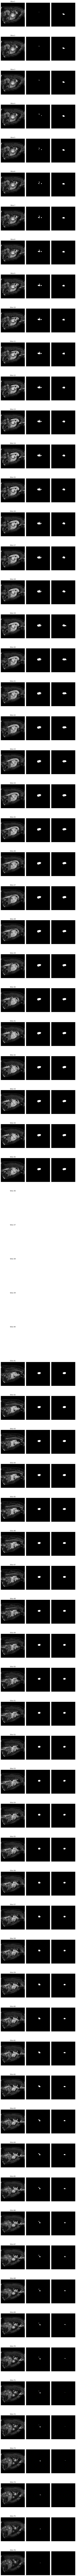

In [292]:
import torch
import matplotlib.pyplot as plt

# データの読み込み（PyTorchのテンソルとして）
images = torch.load('../results/expe_20240507_cenTTA_windowall/Task02_Heart/n07_img.pth')  # 形状は (M, H, W)
labels = torch.load('../results/expe_20240507_cenTTA_windowall/Task02_Heart/n07_label.pth')  # 形状は (M, H, W)
preds = torch.load('../results/expe_20240507_cenTTA_windowall/Task02_Heart/n07_pred.pth')    # 形状は (M, H, W)

# テンソルをnumpy配列に変換
images_np = images.numpy()
labels_np = labels.numpy()
preds_np = preds.numpy()

# スライスの数
M = images.shape[0]

# サブプロットの作成
fig, axs = plt.subplots(M , 3, figsize=(9, 4*M))

for i in range(M):
    # 各スライスを描画
    axs[i, 0].imshow(images_np[i], cmap='gray')
    axs[i, 0].axis('off')  # 軸の非表示
    axs[i, 0].set_title(f'Slice {i+1}')

    axs[i, 1].imshow(labels_np[i], cmap='gray')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(preds_np[i], cmap='gray')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [295]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E
import torch
import torch.nn.functional as F

import os
from scipy.stats import f_oneway

In [296]:
organ = 'Task02_Heart'
# organ = 'Task05_Prostate'

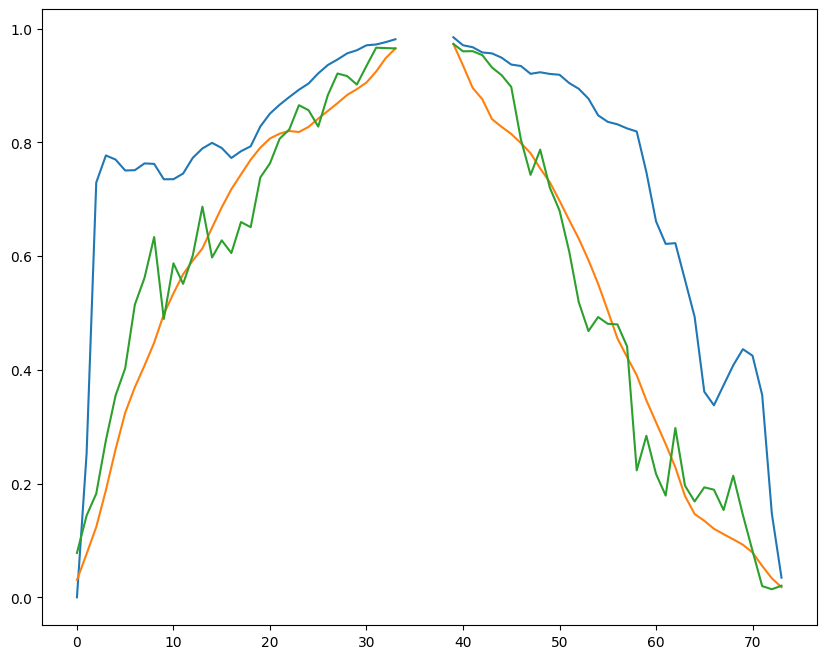

In [305]:
data_windowallTTA= np.loadtxt("../results/expe_20240507_cenTTA_windowall/Task02_Heart/n05", delimiter=',')
data_windowall= np.loadtxt("../results/expe_20240507_cen_windowall/Task02_Heart/n05", delimiter=',')
data_baseline= np.loadtxt("../results/expe_20240507_cen_baseline/Task02_Heart/n05", delimiter=',')
plt.figure(figsize=(10, 8))
plt.plot(data_windowallTTA)
plt.plot(data_windowall)
plt.plot(data_baseline)